In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 0]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
    for i in range(1, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[0]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('../../../_data/Yang2024.csv', index_col=0)

data_df['choice'] = data_df['choice'].map({1:0, 2:1})
data_df['sbj'] -= 1

min_rt = data_df.groupby(by='sbj')['rt'].min()

tr_df, ts_df = make_train_test(data_df, test_size=0.3)

obs_train = np.asarray(tr_df[['rt', 'Right', 'sbj']])
X_train = np.asarray(tr_df[["o1_a1_val", "o1_a2_val", "o2_a1_val", "o2_a2_val",
                            "o1_a1_gaze", "o1_a2_gaze", "o2_a1_gaze", "o2_a2_gaze"]])

obs_test = np.asarray(ts_df[['rt', 'Right', 'sbj']])
X_test = np.asarray(ts_df[["o1_a1_val", "o1_a2_val", "o2_a1_val", "o2_a2_val",
                           "o1_a1_gaze", "o1_a2_gaze", "o2_a1_gaze", "o2_a2_gaze"]])

print(X_train.shape, X_test.shape)

(6804, 8) (2927, 8)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2 + 0.1**14), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 8, 5]
input_shape = 8
output_shape = 2
activation = 'tanh'
n_sbj = data_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 96        
                                                                 
Total params: 429 (1.68 KB)
Trainable params: 429 (1.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=2500)

Epoch 1/2500
1/1 [==============================] - 2s 2s/step - loss: 32259.5527
Epoch 2/2500
1/1 [==============================] - 0s 52ms/step - loss: 32129.4609
Epoch 3/2500
1/1 [==============================] - 0s 40ms/step - loss: 32036.8145
Epoch 4/2500
1/1 [==============================] - 0s 28ms/step - loss: 31959.4082
Epoch 5/2500
1/1 [==============================] - 0s 11ms/step - loss: 31890.4980
Epoch 6/2500
1/1 [==============================] - 0s 9ms/step - loss: 31827.0859
Epoch 7/2500
1/1 [==============================] - 0s 8ms/step - loss: 31767.5703
Epoch 8/2500
1/1 [==============================] - 0s 8ms/step - loss: 31711.0078
Epoch 9/2500
1/1 [==============================] - 0s 8ms/step - loss: 31656.7852
Epoch 10/2500
1/1 [==============================] - 0s 7ms/step - loss: 31604.4844
Epoch 11/2500
1/1 [==============================] - 0s 10ms/step - loss: 31553.8027
Epoch 12/2500
1/1 [==============================] - 0s 17ms/step - loss: 31504.5

1/1 [==============================] - 0s 14ms/step - loss: 28499.3770
Epoch 99/2500
1/1 [==============================] - 0s 9ms/step - loss: 28471.3047
Epoch 100/2500
1/1 [==============================] - 0s 10ms/step - loss: 28443.3555
Epoch 101/2500
1/1 [==============================] - 0s 9ms/step - loss: 28415.5234
Epoch 102/2500
1/1 [==============================] - 0s 13ms/step - loss: 28387.8086
Epoch 103/2500
1/1 [==============================] - 0s 10ms/step - loss: 28360.2090
Epoch 104/2500
1/1 [==============================] - 0s 10ms/step - loss: 28332.7227
Epoch 105/2500
1/1 [==============================] - 0s 10ms/step - loss: 28305.3555
Epoch 106/2500
1/1 [==============================] - 0s 11ms/step - loss: 28278.0996
Epoch 107/2500
1/1 [==============================] - 0s 11ms/step - loss: 28250.9609
Epoch 108/2500
1/1 [==============================] - 0s 8ms/step - loss: 28223.9316
Epoch 109/2500
1/1 [==============================] - 0s 12ms/step - loss

1/1 [==============================] - 0s 14ms/step - loss: 26286.5176
Epoch 194/2500
1/1 [==============================] - 0s 15ms/step - loss: 26265.6914
Epoch 195/2500
1/1 [==============================] - 0s 17ms/step - loss: 26244.8574
Epoch 196/2500
1/1 [==============================] - 0s 13ms/step - loss: 26224.0195
Epoch 197/2500
1/1 [==============================] - 0s 15ms/step - loss: 26203.1719
Epoch 198/2500
1/1 [==============================] - 0s 14ms/step - loss: 26182.3164
Epoch 199/2500
1/1 [==============================] - 0s 16ms/step - loss: 26161.4648
Epoch 200/2500
1/1 [==============================] - 0s 17ms/step - loss: 26140.6094
Epoch 201/2500
1/1 [==============================] - 0s 16ms/step - loss: 26119.7461
Epoch 202/2500
1/1 [==============================] - 0s 15ms/step - loss: 26098.8789
Epoch 203/2500
1/1 [==============================] - 0s 15ms/step - loss: 26078.0078
Epoch 204/2500
1/1 [==============================] - 0s 16ms/step - 

Epoch 289/2500
1/1 [==============================] - 0s 7ms/step - loss: 24158.4922
Epoch 290/2500
1/1 [==============================] - 0s 9ms/step - loss: 24135.9238
Epoch 291/2500
1/1 [==============================] - 0s 8ms/step - loss: 24113.3750
Epoch 292/2500
1/1 [==============================] - 0s 8ms/step - loss: 24090.8594
Epoch 293/2500
1/1 [==============================] - 0s 8ms/step - loss: 24068.3613
Epoch 294/2500
1/1 [==============================] - 0s 9ms/step - loss: 24045.9004
Epoch 295/2500
1/1 [==============================] - 0s 9ms/step - loss: 24023.4590
Epoch 296/2500
1/1 [==============================] - 0s 8ms/step - loss: 24001.0508
Epoch 297/2500
1/1 [==============================] - 0s 9ms/step - loss: 23978.6621
Epoch 298/2500
1/1 [==============================] - 0s 8ms/step - loss: 23956.3086
Epoch 299/2500
1/1 [==============================] - 0s 9ms/step - loss: 23933.9727
Epoch 300/2500
1/1 [==============================] - 0s 8ms/step

Epoch 385/2500
1/1 [==============================] - 0s 15ms/step - loss: 22106.7578
Epoch 386/2500
1/1 [==============================] - 0s 15ms/step - loss: 22086.8496
Epoch 387/2500
1/1 [==============================] - 0s 14ms/step - loss: 22066.9531
Epoch 388/2500
1/1 [==============================] - 0s 13ms/step - loss: 22047.1367
Epoch 389/2500
1/1 [==============================] - 0s 15ms/step - loss: 22027.3418
Epoch 390/2500
1/1 [==============================] - 0s 16ms/step - loss: 22007.6270
Epoch 391/2500
1/1 [==============================] - 0s 14ms/step - loss: 21987.9238
Epoch 392/2500
1/1 [==============================] - 0s 14ms/step - loss: 21968.3125
Epoch 393/2500
1/1 [==============================] - 0s 16ms/step - loss: 21948.7188
Epoch 394/2500
1/1 [==============================] - 0s 13ms/step - loss: 21929.2109
Epoch 395/2500
1/1 [==============================] - 0s 24ms/step - loss: 21909.7246
Epoch 396/2500
1/1 [==============================] - 

Epoch 481/2500
1/1 [==============================] - 0s 10ms/step - loss: 20443.1855
Epoch 482/2500
1/1 [==============================] - 0s 10ms/step - loss: 20427.9805
Epoch 483/2500
1/1 [==============================] - 0s 10ms/step - loss: 20412.8379
Epoch 484/2500
1/1 [==============================] - 0s 13ms/step - loss: 20397.6934
Epoch 485/2500
1/1 [==============================] - 0s 11ms/step - loss: 20382.6152
Epoch 486/2500
1/1 [==============================] - 0s 12ms/step - loss: 20367.5312
Epoch 487/2500
1/1 [==============================] - 0s 9ms/step - loss: 20352.5117
Epoch 488/2500
1/1 [==============================] - 0s 8ms/step - loss: 20337.4961
Epoch 489/2500
1/1 [==============================] - 0s 8ms/step - loss: 20322.5430
Epoch 490/2500
1/1 [==============================] - 0s 8ms/step - loss: 20307.5820
Epoch 491/2500
1/1 [==============================] - 0s 9ms/step - loss: 20292.6895
Epoch 492/2500
1/1 [==============================] - 0s 9m

1/1 [==============================] - 0s 7ms/step - loss: 19124.5781
Epoch 577/2500
1/1 [==============================] - 0s 7ms/step - loss: 19111.9180
Epoch 578/2500
1/1 [==============================] - 0s 9ms/step - loss: 19099.2305
Epoch 579/2500
1/1 [==============================] - 0s 8ms/step - loss: 19086.6133
Epoch 580/2500
1/1 [==============================] - 0s 9ms/step - loss: 19073.9727
Epoch 581/2500
1/1 [==============================] - 0s 9ms/step - loss: 19061.4023
Epoch 582/2500
1/1 [==============================] - 0s 8ms/step - loss: 19048.8047
Epoch 583/2500
1/1 [==============================] - 0s 8ms/step - loss: 19036.2773
Epoch 584/2500
1/1 [==============================] - 0s 8ms/step - loss: 19023.7266
Epoch 585/2500
1/1 [==============================] - 0s 8ms/step - loss: 19011.2441
Epoch 586/2500
1/1 [==============================] - 0s 8ms/step - loss: 18998.7363
Epoch 587/2500
1/1 [==============================] - 0s 28ms/step - loss: 18986

Epoch 672/2500
1/1 [==============================] - 0s 10ms/step - loss: 18002.3047
Epoch 673/2500
1/1 [==============================] - 0s 10ms/step - loss: 17991.5938
Epoch 674/2500
1/1 [==============================] - 0s 9ms/step - loss: 17980.7852
Epoch 675/2500
1/1 [==============================] - 0s 9ms/step - loss: 17970.1094
Epoch 676/2500
1/1 [==============================] - 0s 15ms/step - loss: 17959.3340
Epoch 677/2500
1/1 [==============================] - 0s 15ms/step - loss: 17948.6953
Epoch 678/2500
1/1 [==============================] - 0s 14ms/step - loss: 17937.9492
Epoch 679/2500
1/1 [==============================] - 0s 17ms/step - loss: 17927.3477
Epoch 680/2500
1/1 [==============================] - 0s 15ms/step - loss: 17916.6328
Epoch 681/2500
1/1 [==============================] - 0s 14ms/step - loss: 17906.0664
Epoch 682/2500
1/1 [==============================] - 0s 11ms/step - loss: 17895.3848
Epoch 683/2500
1/1 [==============================] - 0s

1/1 [==============================] - 0s 8ms/step - loss: 17042.7949
Epoch 768/2500
1/1 [==============================] - 0s 9ms/step - loss: 17033.0898
Epoch 769/2500
1/1 [==============================] - 0s 10ms/step - loss: 17023.6191
Epoch 770/2500
1/1 [==============================] - 0s 18ms/step - loss: 17013.9297
Epoch 771/2500
1/1 [==============================] - 0s 28ms/step - loss: 17004.4688
Epoch 772/2500
1/1 [==============================] - 0s 42ms/step - loss: 16994.7891
Epoch 773/2500
1/1 [==============================] - 0s 29ms/step - loss: 16985.3438
Epoch 774/2500
1/1 [==============================] - 0s 22ms/step - loss: 16975.6816
Epoch 775/2500
1/1 [==============================] - 0s 21ms/step - loss: 16966.2422
Epoch 776/2500
1/1 [==============================] - 0s 20ms/step - loss: 16956.5781
Epoch 777/2500
1/1 [==============================] - 0s 21ms/step - loss: 16947.1602
Epoch 778/2500
1/1 [==============================] - 0s 12ms/step - lo

1/1 [==============================] - 0s 15ms/step - loss: 16146.4688
Epoch 863/2500
1/1 [==============================] - 0s 17ms/step - loss: 16136.4883
Epoch 864/2500
1/1 [==============================] - 0s 15ms/step - loss: 16126.6260
Epoch 865/2500
1/1 [==============================] - 0s 14ms/step - loss: 16117.4678
Epoch 866/2500
1/1 [==============================] - 0s 14ms/step - loss: 16108.5371
Epoch 867/2500
1/1 [==============================] - 0s 16ms/step - loss: 16100.4170
Epoch 868/2500
1/1 [==============================] - 0s 11ms/step - loss: 16093.0986
Epoch 869/2500
1/1 [==============================] - 0s 12ms/step - loss: 16086.5645
Epoch 870/2500
1/1 [==============================] - 0s 10ms/step - loss: 16078.9531
Epoch 871/2500
1/1 [==============================] - 0s 10ms/step - loss: 16068.6445
Epoch 872/2500
1/1 [==============================] - 0s 10ms/step - loss: 16057.8193
Epoch 873/2500
1/1 [==============================] - 0s 12ms/step - 

1/1 [==============================] - 0s 8ms/step - loss: 15331.7217
Epoch 958/2500
1/1 [==============================] - 0s 10ms/step - loss: 15322.8047
Epoch 959/2500
1/1 [==============================] - 0s 9ms/step - loss: 15314.6582
Epoch 960/2500
1/1 [==============================] - 0s 8ms/step - loss: 15306.8457
Epoch 961/2500
1/1 [==============================] - 0s 9ms/step - loss: 15299.8682
Epoch 962/2500
1/1 [==============================] - 0s 8ms/step - loss: 15293.5381
Epoch 963/2500
1/1 [==============================] - 0s 9ms/step - loss: 15288.3066
Epoch 964/2500
1/1 [==============================] - 0s 8ms/step - loss: 15282.4707
Epoch 965/2500
1/1 [==============================] - 0s 9ms/step - loss: 15274.5742
Epoch 966/2500
1/1 [==============================] - 0s 10ms/step - loss: 15265.0479
Epoch 967/2500
1/1 [==============================] - 0s 9ms/step - loss: 15254.3135
Epoch 968/2500
1/1 [==============================] - 0s 9ms/step - loss: 1524

1/1 [==============================] - 0s 13ms/step - loss: 14618.7559
Epoch 1053/2500
1/1 [==============================] - 0s 9ms/step - loss: 14612.5430
Epoch 1054/2500
1/1 [==============================] - 0s 8ms/step - loss: 14606.0596
Epoch 1055/2500
1/1 [==============================] - 0s 8ms/step - loss: 14599.4443
Epoch 1056/2500
1/1 [==============================] - 0s 7ms/step - loss: 14591.5342
Epoch 1057/2500
1/1 [==============================] - 0s 8ms/step - loss: 14583.9365
Epoch 1058/2500
1/1 [==============================] - 0s 9ms/step - loss: 14575.9551
Epoch 1059/2500
1/1 [==============================] - 0s 8ms/step - loss: 14568.8701
Epoch 1060/2500
1/1 [==============================] - 0s 10ms/step - loss: 14562.4717
Epoch 1061/2500
1/1 [==============================] - 0s 8ms/step - loss: 14557.2412
Epoch 1062/2500
1/1 [==============================] - 0s 9ms/step - loss: 14552.8340
Epoch 1063/2500
1/1 [==============================] - 0s 7ms/step -

Epoch 1147/2500
1/1 [==============================] - 0s 11ms/step - loss: 13992.2461
Epoch 1148/2500
1/1 [==============================] - 0s 10ms/step - loss: 13985.7285
Epoch 1149/2500
1/1 [==============================] - 0s 11ms/step - loss: 13980.0459
Epoch 1150/2500
1/1 [==============================] - 0s 10ms/step - loss: 13973.5176
Epoch 1151/2500
1/1 [==============================] - 0s 11ms/step - loss: 13967.8828
Epoch 1152/2500
1/1 [==============================] - 0s 11ms/step - loss: 13961.3438
Epoch 1153/2500
1/1 [==============================] - 0s 11ms/step - loss: 13955.7441
Epoch 1154/2500
1/1 [==============================] - 0s 7ms/step - loss: 13949.2031
Epoch 1155/2500
1/1 [==============================] - 0s 8ms/step - loss: 13943.6426
Epoch 1156/2500
1/1 [==============================] - 0s 8ms/step - loss: 13937.1104
Epoch 1157/2500
1/1 [==============================] - 0s 8ms/step - loss: 13931.5742
Epoch 1158/2500
1/1 [==========================

1/1 [==============================] - 0s 8ms/step - loss: 13462.4775
Epoch 1243/2500
1/1 [==============================] - 0s 8ms/step - loss: 13459.0186
Epoch 1244/2500
1/1 [==============================] - 0s 8ms/step - loss: 13452.4707
Epoch 1245/2500
1/1 [==============================] - 0s 9ms/step - loss: 13449.0625
Epoch 1246/2500
1/1 [==============================] - 0s 9ms/step - loss: 13442.4707
Epoch 1247/2500
1/1 [==============================] - 0s 8ms/step - loss: 13439.0986
Epoch 1248/2500
1/1 [==============================] - 0s 8ms/step - loss: 13432.4785
Epoch 1249/2500
1/1 [==============================] - 0s 8ms/step - loss: 13429.1221
Epoch 1250/2500
1/1 [==============================] - 0s 9ms/step - loss: 13422.5742
Epoch 1251/2500
1/1 [==============================] - 0s 11ms/step - loss: 13419.3262
Epoch 1252/2500
1/1 [==============================] - 0s 17ms/step - loss: 13412.7051
Epoch 1253/2500
1/1 [==============================] - 0s 23ms/step 

1/1 [==============================] - 0s 8ms/step - loss: 13035.6406
Epoch 1338/2500
1/1 [==============================] - 0s 9ms/step - loss: 13028.1982
Epoch 1339/2500
1/1 [==============================] - 0s 8ms/step - loss: 13027.3906
Epoch 1340/2500
1/1 [==============================] - 0s 8ms/step - loss: 13019.9834
Epoch 1341/2500
1/1 [==============================] - 0s 8ms/step - loss: 13019.3203
Epoch 1342/2500
1/1 [==============================] - 0s 9ms/step - loss: 13012.0996
Epoch 1343/2500
1/1 [==============================] - 0s 10ms/step - loss: 13011.5781
Epoch 1344/2500
1/1 [==============================] - 0s 10ms/step - loss: 13004.2305
Epoch 1345/2500
1/1 [==============================] - 0s 11ms/step - loss: 13003.7969
Epoch 1346/2500
1/1 [==============================] - 0s 12ms/step - loss: 12996.3975
Epoch 1347/2500
1/1 [==============================] - 0s 61ms/step - loss: 12995.9980
Epoch 1348/2500
1/1 [==============================] - 0s 54ms/st

Epoch 1432/2500
1/1 [==============================] - 0s 14ms/step - loss: 12689.1006
Epoch 1433/2500
1/1 [==============================] - 0s 15ms/step - loss: 12691.1621
Epoch 1434/2500
1/1 [==============================] - 0s 15ms/step - loss: 12683.0996
Epoch 1435/2500
1/1 [==============================] - 0s 13ms/step - loss: 12685.6523
Epoch 1436/2500
1/1 [==============================] - 0s 13ms/step - loss: 12677.0225
Epoch 1437/2500
1/1 [==============================] - 0s 9ms/step - loss: 12679.2451
Epoch 1438/2500
1/1 [==============================] - 0s 9ms/step - loss: 12670.5283
Epoch 1439/2500
1/1 [==============================] - 0s 9ms/step - loss: 12673.1562
Epoch 1440/2500
1/1 [==============================] - 0s 9ms/step - loss: 12664.0400
Epoch 1441/2500
1/1 [==============================] - 0s 11ms/step - loss: 12666.3535
Epoch 1442/2500
1/1 [==============================] - 0s 8ms/step - loss: 12657.5078
Epoch 1443/2500
1/1 [===========================

1/1 [==============================] - 0s 19ms/step - loss: 12422.2822
Epoch 1527/2500
1/1 [==============================] - 0s 19ms/step - loss: 12428.4980
Epoch 1528/2500
1/1 [==============================] - 0s 18ms/step - loss: 12418.1533
Epoch 1529/2500
1/1 [==============================] - 0s 18ms/step - loss: 12422.5049
Epoch 1530/2500
1/1 [==============================] - 0s 20ms/step - loss: 12413.9551
Epoch 1531/2500
1/1 [==============================] - 0s 20ms/step - loss: 12421.1826
Epoch 1532/2500
1/1 [==============================] - 0s 12ms/step - loss: 12409.2715
Epoch 1533/2500
1/1 [==============================] - 0s 10ms/step - loss: 12412.9062
Epoch 1534/2500
1/1 [==============================] - 0s 9ms/step - loss: 12400.7852
Epoch 1535/2500
1/1 [==============================] - 0s 9ms/step - loss: 12404.1504
Epoch 1536/2500
1/1 [==============================] - 0s 9ms/step - loss: 12395.5195
Epoch 1537/2500
1/1 [==============================] - 0s 9ms/

1/1 [==============================] - 0s 8ms/step - loss: 12209.0469
Epoch 1621/2500
1/1 [==============================] - 0s 8ms/step - loss: 12256.6318
Epoch 1622/2500
1/1 [==============================] - 0s 8ms/step - loss: 12230.8760
Epoch 1623/2500
1/1 [==============================] - 0s 8ms/step - loss: 12231.6523
Epoch 1624/2500
1/1 [==============================] - 0s 8ms/step - loss: 12206.0322
Epoch 1625/2500
1/1 [==============================] - 0s 8ms/step - loss: 12203.9375
Epoch 1626/2500
1/1 [==============================] - 0s 8ms/step - loss: 12187.7910
Epoch 1627/2500
1/1 [==============================] - 0s 9ms/step - loss: 12190.8643
Epoch 1628/2500
1/1 [==============================] - 0s 8ms/step - loss: 12182.2656
Epoch 1629/2500
1/1 [==============================] - 0s 8ms/step - loss: 12190.7451
Epoch 1630/2500
1/1 [==============================] - 0s 8ms/step - loss: 12188.4863
Epoch 1631/2500
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 19ms/step - loss: 12072.5078
Epoch 1717/2500
1/1 [==============================] - 0s 22ms/step - loss: 12072.3896
Epoch 1718/2500
1/1 [==============================] - 0s 25ms/step - loss: 12243.5488
Epoch 1719/2500
1/1 [==============================] - 0s 14ms/step - loss: 12081.4990
Epoch 1720/2500
1/1 [==============================] - 0s 15ms/step - loss: 12038.9902
Epoch 1721/2500
1/1 [==============================] - 0s 12ms/step - loss: 11999.1543
Epoch 1722/2500
1/1 [==============================] - 0s 9ms/step - loss: 11993.2080
Epoch 1723/2500
1/1 [==============================] - 0s 10ms/step - loss: 11981.8516
Epoch 1724/2500
1/1 [==============================] - 0s 8ms/step - loss: 12000.5898
Epoch 1725/2500
1/1 [==============================] - 0s 9ms/step - loss: 11992.0820
Epoch 1726/2500
1/1 [==============================] - 0s 10ms/step - loss: 12002.0771
Epoch 1727/2500
1/1 [==============================] - 0s 10ms

1/1 [==============================] - 0s 8ms/step - loss: 12019.7959
Epoch 1811/2500
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 1812/2500
1/1 [==============================] - 0s 9ms/step - loss: 11994.7168
Epoch 1813/2500
1/1 [==============================] - 0s 9ms/step - loss: 11935.4316
Epoch 1814/2500
1/1 [==============================] - 0s 8ms/step - loss: 11919.9551
Epoch 1815/2500
1/1 [==============================] - 0s 8ms/step - loss: 11889.0371
Epoch 1816/2500
1/1 [==============================] - 0s 9ms/step - loss: 11893.2256
Epoch 1817/2500
1/1 [==============================] - 0s 8ms/step - loss: 11875.9121
Epoch 1818/2500
1/1 [==============================] - 0s 8ms/step - loss: 11892.6797
Epoch 1819/2500
1/1 [==============================] - 0s 8ms/step - loss: 11875.4102
Epoch 1820/2500
1/1 [==============================] - 0s 8ms/step - loss: 11883.3359
Epoch 1821/2500
1/1 [==============================] - 0s 8ms/step - loss: 11

1/1 [==============================] - 0s 9ms/step - loss: 11778.8086
Epoch 1907/2500
1/1 [==============================] - 0s 8ms/step - loss: 11791.4531
Epoch 1908/2500
1/1 [==============================] - 0s 9ms/step - loss: 11786.8438
Epoch 1909/2500
1/1 [==============================] - 0s 9ms/step - loss: 11806.8633
Epoch 1910/2500
1/1 [==============================] - 0s 9ms/step - loss: 11798.5020
Epoch 1911/2500
1/1 [==============================] - 0s 9ms/step - loss: 11820.8320
Epoch 1912/2500
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 1913/2500
1/1 [==============================] - 0s 17ms/step - loss: 11809.4570
Epoch 1914/2500
1/1 [==============================] - 0s 29ms/step - loss: 11784.2998
Epoch 1915/2500
1/1 [==============================] - 0s 70ms/step - loss: 11799.1377
Epoch 1916/2500
1/1 [==============================] - 0s 28ms/step - loss: 11787.2090
Epoch 1917/2500
1/1 [==============================] - 0s 28ms/step - los

1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 2002/2500
1/1 [==============================] - 0s 8ms/step - loss: 11639.4258
Epoch 2003/2500
1/1 [==============================] - 0s 8ms/step - loss: 11686.1865
Epoch 2004/2500
1/1 [==============================] - 0s 8ms/step - loss: 11739.2930
Epoch 2005/2500
1/1 [==============================] - 0s 8ms/step - loss: 11828.6836
Epoch 2006/2500
1/1 [==============================] - 0s 8ms/step - loss: 11826.6504
Epoch 2007/2500
1/1 [==============================] - 0s 8ms/step - loss: 11830.3789
Epoch 2008/2500
1/1 [==============================] - 0s 8ms/step - loss: 11738.0117
Epoch 2009/2500
1/1 [==============================] - 0s 8ms/step - loss: 11711.4893
Epoch 2010/2500
1/1 [==============================] - 0s 8ms/step - loss: 11668.6035
Epoch 2011/2500
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 2012/2500
1/1 [==============================] - 0s 8ms/step - loss: 11689.394

1/1 [==============================] - 0s 8ms/step - loss: 11590.5820
Epoch 2098/2500
1/1 [==============================] - 0s 8ms/step - loss: 11578.3848
Epoch 2099/2500
1/1 [==============================] - 0s 8ms/step - loss: 11589.2734
Epoch 2100/2500
1/1 [==============================] - 0s 8ms/step - loss: 11549.9609
Epoch 2101/2500
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 2102/2500
1/1 [==============================] - 0s 8ms/step - loss: 11627.5371
Epoch 2103/2500
1/1 [==============================] - 0s 9ms/step - loss: 11664.6953
Epoch 2104/2500
1/1 [==============================] - 0s 8ms/step - loss: 11657.0273
Epoch 2105/2500
1/1 [==============================] - 0s 8ms/step - loss: 11676.0869
Epoch 2106/2500
1/1 [==============================] - 0s 8ms/step - loss: 11640.3301
Epoch 2107/2500
1/1 [==============================] - 0s 8ms/step - loss: 11642.1289
Epoch 2108/2500
1/1 [==============================] - 0s 7ms/step - loss: 11

1/1 [==============================] - 0s 8ms/step - loss: 11664.6641
Epoch 2195/2500
1/1 [==============================] - 0s 8ms/step - loss: 11626.1660
Epoch 2196/2500
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 2197/2500
1/1 [==============================] - 0s 8ms/step - loss: 11523.8848
Epoch 2198/2500
1/1 [==============================] - 0s 8ms/step - loss: 11489.6045
Epoch 2199/2500
1/1 [==============================] - 0s 8ms/step - loss: 11491.6924
Epoch 2200/2500
1/1 [==============================] - 0s 8ms/step - loss: 11489.5898
Epoch 2201/2500
1/1 [==============================] - 0s 8ms/step - loss: 11504.4307
Epoch 2202/2500
1/1 [==============================] - 0s 8ms/step - loss: 11528.9258
Epoch 2203/2500
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 2204/2500
1/1 [==============================] - 0s 8ms/step - loss: 11603.6777
Epoch 2205/2500
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch

1/1 [==============================] - 0s 10ms/step - loss: 11576.6523
Epoch 2292/2500
1/1 [==============================] - 0s 9ms/step - loss: nan
Epoch 2293/2500
1/1 [==============================] - 0s 9ms/step - loss: 11533.6230
Epoch 2294/2500
1/1 [==============================] - 0s 10ms/step - loss: nan
Epoch 2295/2500
1/1 [==============================] - 0s 10ms/step - loss: 11493.2285
Epoch 2296/2500
1/1 [==============================] - 0s 10ms/step - loss: 11476.0000
Epoch 2297/2500
1/1 [==============================] - 0s 9ms/step - loss: 11481.8193
Epoch 2298/2500
1/1 [==============================] - 0s 11ms/step - loss: 11466.6689
Epoch 2299/2500
1/1 [==============================] - 0s 9ms/step - loss: 11521.9648
Epoch 2300/2500
1/1 [==============================] - 0s 9ms/step - loss: nan
Epoch 2301/2500
1/1 [==============================] - 0s 9ms/step - loss: 11488.9805
Epoch 2302/2500
1/1 [==============================] - 0s 9ms/step - loss: 11469.7041


Epoch 2388/2500
1/1 [==============================] - 0s 9ms/step - loss: 11321.4238
Epoch 2389/2500
1/1 [==============================] - 0s 9ms/step - loss: 11321.8633
Epoch 2390/2500
1/1 [==============================] - 0s 9ms/step - loss: 11337.8291
Epoch 2391/2500
1/1 [==============================] - 0s 10ms/step - loss: 11379.3984
Epoch 2392/2500
1/1 [==============================] - 0s 9ms/step - loss: nan
Epoch 2393/2500
1/1 [==============================] - 0s 9ms/step - loss: 11685.9609
Epoch 2394/2500
1/1 [==============================] - 0s 11ms/step - loss: 11716.1592
Epoch 2395/2500
1/1 [==============================] - 0s 10ms/step - loss: nan
Epoch 2396/2500
1/1 [==============================] - 0s 19ms/step - loss: 11397.3555
Epoch 2397/2500
1/1 [==============================] - 0s 9ms/step - loss: 11381.1113
Epoch 2398/2500
1/1 [==============================] - 0s 9ms/step - loss: 11388.9238
Epoch 2399/2500
1/1 [==============================] - 0s 10ms/s

1/1 [==============================] - 0s 20ms/step - loss: 11319.4980
Epoch 2486/2500
1/1 [==============================] - 0s 17ms/step - loss: 11332.2559
Epoch 2487/2500
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 2488/2500
1/1 [==============================] - 0s 18ms/step - loss: 11384.8945
Epoch 2489/2500
1/1 [==============================] - 0s 15ms/step - loss: nan
Epoch 2490/2500
1/1 [==============================] - 0s 18ms/step - loss: 11502.0332
Epoch 2491/2500
1/1 [==============================] - 0s 26ms/step - loss: 11357.0723
Epoch 2492/2500
1/1 [==============================] - 0s 12ms/step - loss: 11365.3076
Epoch 2493/2500
1/1 [==============================] - 0s 10ms/step - loss: 11398.7705
Epoch 2494/2500
1/1 [==============================] - 0s 12ms/step - loss: 11464.4541
Epoch 2495/2500
1/1 [==============================] - 0s 10ms/step - loss: nan
Epoch 2496/2500
1/1 [==============================] - 0s 9ms/step - loss: 11497

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

92/92 [==============================] - 0s 1ms/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

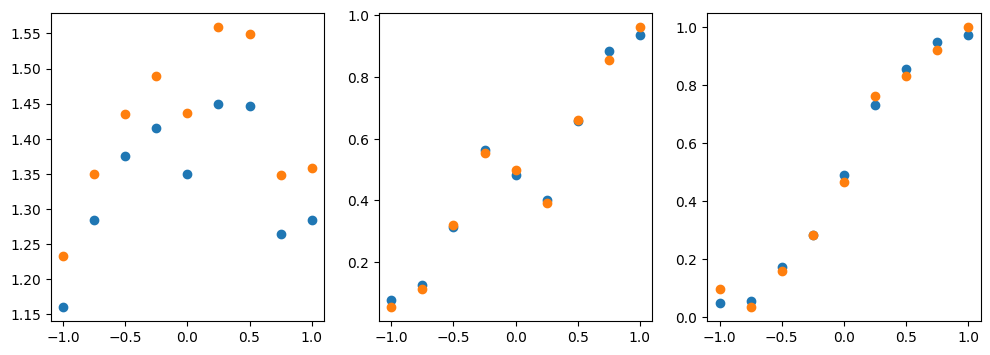

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['rt'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(132)
plt.scatter(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), y=pred_bhv.groupby(by='value_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean());

plt.subplot(133)
plt.scatter(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(), y=pred_bhv.groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean());

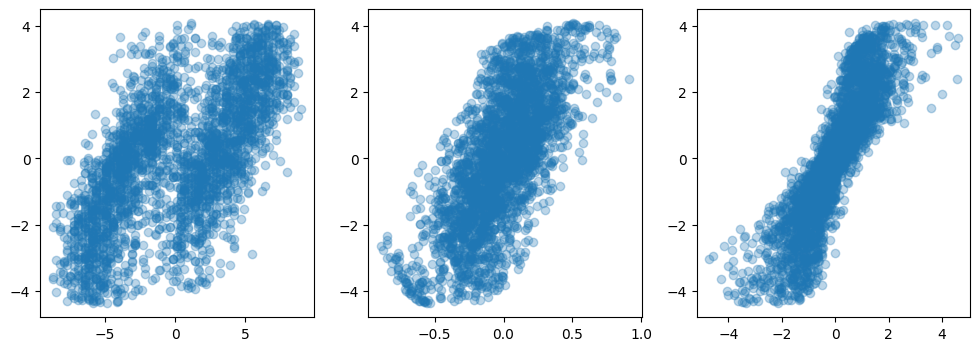

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] + X_test[:, 1] - X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 4] + X_test[:, 5] - X_test[:, 6] - X_test[:, 7], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
a1 = X_test[:, 0]*X_test[:, 4] +X_test[:, 1]*X_test[:, 5]
a2 = X_test[:, 2]*X_test[:, 6] +X_test[:, 3]*X_test[:, 7]
plt.scatter(a1 - a2, pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

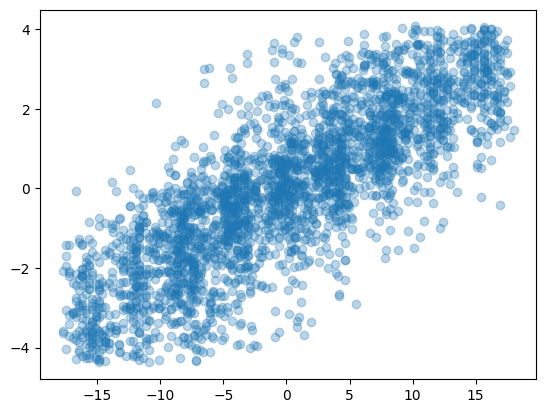

In [14]:
plt.scatter(4*X_test[:, 0] + X_test[:, 1] - 4*X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);